<a href="https://colab.research.google.com/github/andrew76lim/Predicting-Future-Sales-Project/blob/main/Andrew_Lim_Projecting_Future_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from itertools import product
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

DATA_FOLDER = "./"

In [ ]:
# loading all the data

sales = pd.read_csv(f"{DATA_FOLDER}/sales_train.csv")
test  = pd.read_csv(f"{DATA_FOLDER}/test.csv")
items = pd.read_csv(f"{DATA_FOLDER}/items.csv")
cats  = pd.read_csv(f"{DATA_FOLDER}/item_categories.csv")
shops = pd.read_csv(f"{DATA_FOLDER}/shops.csv")

In [ ]:
# cleaning and shop fixes

sales["date"] = pd.to_datetime(sales["date"], format="%d.%m.%Y")

# keep only shops that appear in test

sales = sales[sales["shop_id"].isin(test["shop_id"].unique())]

# remove price / count outliers

sales = sales[(sales["item_price"] > 0) & (sales["item_price"] < 100000)]
sales = sales[(sales["item_cnt_day"] > 0) & (sales["item_cnt_day"] < 1001)]

# fix duplicate shop IDs (standard for this comp)

sales.loc[sales.shop_id == 0,  "shop_id"] = 57
test.loc[test.shop_id == 0,   "shop_id"] = 57
sales.loc[sales.shop_id == 1,  "shop_id"] = 58
test.loc[test.shop_id == 1,   "shop_id"] = 58
sales.loc[sales.shop_id == 10, "shop_id"] = 11
test.loc[test.shop_id == 10,  "shop_id"] = 11
sales.loc[sales.shop_id == 39, "shop_id"] = 40
test.loc[test.shop_id == 39,  "shop_id"] = 40

# revenue per row

sales["revenue"] = sales["item_price"] * sales["item_cnt_day"]

sales["date_block_num"] = sales["date_block_num"].astype("int8")
test["ID"] = test["ID"].astype("int32")

In [ ]:
# build monthly shop item index

def create_testlike_train(df):
    """
    Create complete (date_block_num, month_start, shop_id, item_id) grid and
    aggregate monthly item_cnt and revenue.
    """
    matrix = []
    min_date = df["date"].min()
    for m in range(df["date_block_num"].min(), df["date_block_num"].max() + 1):
        shops_m = df[df["date_block_num"] == m]["shop_id"].unique()
        items_m = df[df["date_block_num"] == m]["item_id"].unique()
        month_start = min_date + pd.tseries.offsets.DateOffset(months=m)
        matrix.append(
            np.array(list(product([m], [month_start], shops_m, items_m)))
        )

    df_new = pd.DataFrame(
        np.vstack(matrix),
        columns=["date_block_num", "month_start", "shop_id", "item_id"]
    )

    # monthly sums

    pivot = (
        df.groupby(["date_block_num", "shop_id", "item_id"], as_index=False)
          .agg({"item_cnt_day": "sum", "revenue": "sum"})
    )

    # number of days with greater than 0 sales

    pivot2 = (
        df[df["item_cnt_day"] > 0]
        .groupby(["date_block_num", "shop_id", "item_id"], as_index=False)
        .agg({"item_cnt_day": "count"})
        .rename(columns={"item_cnt_day": "purch_cnt_month"})
    )

    df_new = df_new.merge(pivot, on=["date_block_num", "shop_id", "item_id"], how="left")
    df_new = df_new.merge(pivot2, on=["date_block_num", "shop_id", "item_id"], how="left")

    df_new.rename(columns={"item_cnt_day": "item_cnt_month_uncl"}, inplace=True)

    df_new["item_cnt_month_uncl"] = df_new["item_cnt_month_uncl"].fillna(0)
    df_new["item_cnt_month"] = df_new["item_cnt_month_uncl"].clip(0, 20)
    df_new["revenue"] = df_new["revenue"].fillna(0)
    df_new["purch_cnt_month"] = df_new["purch_cnt_month"].fillna(0)

    df_new["ID"] = -1
    return df_new

print("Building monthly train matrix...")
df = create_testlike_train(sales)

Building monthly train matrix...


In [ ]:
# attatch test as month 34

test["date_block_num"] = df["date_block_num"].max() + 1  # 34
test["month_start"] = df["month_start"].max() + pd.tseries.offsets.DateOffset(months=1)
test["item_cnt_month_uncl"] = 0
test["item_cnt_month"] = 0
test["revenue"] = 0
test["purch_cnt_month"] = 0

train_cols = [
    "ID", "date_block_num", "month_start", "shop_id", "item_id",
    "item_cnt_month_uncl", "item_cnt_month", "purch_cnt_month", "revenue"
]

df = df[train_cols]
test = test[train_cols]

df = pd.concat([df, test], ignore_index=True)
print("Combined df shape:", df.shape)

Combined df shape: (8807930, 9)


In [ ]:
# data types and calender features

df["ID"] = df["ID"].astype("int32")
df["date_block_num"] = df["date_block_num"].astype("int8")
df["shop_id"] = df["shop_id"].astype("int8")
df["item_id"] = df["item_id"].astype("int16")
df["item_cnt_month"] = df["item_cnt_month"].astype("float32")
df["item_cnt_month_uncl"] = df["item_cnt_month_uncl"].astype("float32")
df["revenue"] = df["revenue"].astype("float32")
df["purch_cnt_month"] = df["purch_cnt_month"].astype("float32")

df["month"] = df["month_start"].dt.month.astype("int8")
df.drop(columns=["month_start"], inplace=True)

# days_in_m from raw sales
days_in_m = (
    sales.groupby("date_block_num")["date"]
    .nunique()
    .reset_index()
    .rename(columns={"date": "days_in_m"})
)
days_in_m["days_in_m"] = days_in_m["days_in_m"].astype("int8")
df = df.merge(days_in_m, on="date_block_num", how="left")


In [ ]:
# items, categories, and shop encodings

# items

items_small = items[["item_id", "item_category_id"]].copy()
items_small["item_id"] = items_small["item_id"].astype("int16")
items_small["item_category_id"] = items_small["item_category_id"].astype("int8")
df = df.merge(items_small, on="item_id", how="left")

# categories

cats["type"] = cats["item_category_name"].apply(lambda x: x.split(" - ")[0])
cats["subtype"] = cats["item_category_name"].apply(
    lambda x: x.split(" - ")[1] if " - " in x else "Other"
)
cats["item_category_type_encoded"] = (
    cats["type"].astype("category").cat.codes.astype("int8")
)
cats["item_category_subtype_encoded"] = (
    cats["subtype"].astype("category").cat.codes.astype("int8")
)
df = df.merge(
    cats[["item_category_id", "item_category_type_encoded", "item_category_subtype_encoded"]],
    on="item_category_id",
    how="left",
)

# shops

shops["shop_city"] = shops["shop_name"].str.split().str[0]
shops["shop_type"] = shops["shop_name"].str.split().str[1]
shops["shop_city_encoded"] = shops["shop_city"].astype("category").cat.codes.astype("int8")
shops["shop_type_encoded"] = shops["shop_type"].astype("category").cat.codes.astype("int8")

shops_small = shops[["shop_id", "shop_city_encoded", "shop_type_encoded"]].copy()
shops_small["shop_id"] = shops_small["shop_id"].astype("int8")
df = df.merge(shops_small, on="shop_id", how="left")

In [ ]:
# mean encoded features

def add_mean_encoded_feat(df):
    """
    Mean encodings:
      - lagged_it_mean: item-level mean of item_cnt_month up to previous month
      - lagged_sh_it_mean: shop-item-level mean up to previous month
    """

    # item level
    pivot_it = (
        df.groupby(["item_id", "date_block_num"], as_index=False)
          .agg(item_cnt_sum=("item_cnt_month", "sum"),
               item_cnt_cnt=("item_cnt_month", "count"))
    )
    pivot_it = pivot_it.sort_values(["item_id", "date_block_num"])

    pivot_it["cum_sum"] = (
        pivot_it.groupby("item_id")["item_cnt_sum"].cumsum()
        - pivot_it["item_cnt_sum"]
    )
    pivot_it["cum_cnt"] = (
        pivot_it.groupby("item_id")["item_cnt_cnt"].cumsum()
        - pivot_it["item_cnt_cnt"]
    )

    pivot_it["lagged_it_mean"] = (
        pivot_it["cum_sum"] / pivot_it["cum_cnt"]
    ).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    pivot_it = pivot_it[["item_id", "date_block_num", "lagged_it_mean"]]
    df = df.merge(pivot_it, on=["item_id", "date_block_num"], how="left")

    # shop item level

    pivot_sh_it = (
        df.groupby(["shop_id", "item_id", "date_block_num"], as_index=False)
          .agg(item_cnt_sum=("item_cnt_month", "sum"),
               item_cnt_cnt=("item_cnt_month", "count"))
    )
    pivot_sh_it = pivot_sh_it.sort_values(["shop_id", "item_id", "date_block_num"])

    pivot_sh_it["cum_sum"] = (
        pivot_sh_it.groupby(["shop_id", "item_id"])["item_cnt_sum"].cumsum()
        - pivot_sh_it["item_cnt_sum"]
    )
    pivot_sh_it["cum_cnt"] = (
        pivot_sh_it.groupby(["shop_id", "item_id"])["item_cnt_cnt"].cumsum()
        - pivot_sh_it["item_cnt_cnt"]
    )

    pivot_sh_it["lagged_sh_it_mean"] = (
        pivot_sh_it["cum_sum"] / pivot_sh_it["cum_cnt"]
    ).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    pivot_sh_it = pivot_sh_it[["shop_id", "item_id", "date_block_num", "lagged_sh_it_mean"]]
    df = df.merge(pivot_sh_it, on=["shop_id", "item_id", "date_block_num"], how="left")

    df["lagged_it_mean"] = df["lagged_it_mean"].fillna(0.0).astype("float32")
    df["lagged_sh_it_mean"] = df["lagged_sh_it_mean"].fillna(0.0).astype("float32")

    return df

print("Adding mean-encoded features...")
df = add_mean_encoded_feat(df)

Adding mean-encoded features...


In [ ]:
# generic lag feature helper (idea pulled from the examples)

def add_lag_feat(df, col_to_agg, group_levels, n_lags, aggfunc="mean", clip=False):
    """
    Create lag features for aggregated statistics over group_levels.
    col_to_agg: list with one column name, e.g. ['item_cnt_month']
    group_levels: e.g. ['date_block_num','shop_id','item_id'] or ['date_block_num','item_id']
    n_lags: list of integers (lag steps)
    aggfunc: 'mean' or 'sum'
    """
    idx_cols = ["date_block_num", "shop_id", "item_id"]
    new_col_title_code = "_".join([x for x in group_levels if x != "date_block_num"])

    # aggregate

    pivot = (
        df.groupby(group_levels, as_index=False)[col_to_agg[0]]
        .agg(aggfunc)
    )
    agg_col_name = col_to_agg[0] + "_" + aggfunc
    pivot.rename(columns={col_to_agg[0]: agg_col_name}, inplace=True)

    merge_cols = list(set(idx_cols + group_levels))
    df_tech = df[merge_cols].merge(pivot, on=group_levels, how="left")

    new_cols = []
    for lag in n_lags:
        df_shift = df_tech[idx_cols + [agg_col_name]].copy()
        df_shift["date_block_num"] = df_shift["date_block_num"] + lag
        new_name = f"{col_to_agg[0]}_{new_col_title_code}_{aggfunc}_lag_{lag}"
        df_shift.rename(columns={agg_col_name: new_name}, inplace=True)
        new_cols.append(new_name)
        df = df.merge(df_shift, on=idx_cols, how="left")

    for col in new_cols:
        df[col] = df[col].fillna(0.0)
        if clip:
            df[col] = df[col].clip(0, 20)
        df[col] = df[col].astype("float32")

    return df

print("Adding lag features...")

# shop–item sales lags

df = add_lag_feat(
    df,
    col_to_agg=["item_cnt_month"],
    group_levels=["date_block_num", "shop_id", "item_id"],
    n_lags=[1, 2, 3, 6, 12],
    aggfunc="sum",
    clip=True,
)

# item mean lags

df = add_lag_feat(
    df,
    col_to_agg=["item_cnt_month"],
    group_levels=["date_block_num", "item_id"],
    n_lags=[1, 2, 3],
    aggfunc="mean",
    clip=True,
)

# shop mean lags

df = add_lag_feat(
    df,
    col_to_agg=["item_cnt_month"],
    group_levels=["date_block_num", "shop_id"],
    n_lags=[1, 2, 3],
    aggfunc="mean",
    clip=True,
)

# category mean lags

df = add_lag_feat(
    df,
    col_to_agg=["item_cnt_month"],
    group_levels=["date_block_num", "item_category_id"],
    n_lags=[1, 2, 3],
    aggfunc="mean",
    clip=True,
)

Adding lag features...


In [ ]:
# price features (similar to example)

# avg price in a month for shop item

df["avg_price_mnth"] = 0.0
mask = df["item_cnt_month_uncl"] > 0
df.loc[mask, "avg_price_mnth"] = (
    df.loc[mask, "revenue"] / df.loc[mask, "item_cnt_month_uncl"]
)
df["avg_price_mnth"] = (
    df["avg_price_mnth"].replace([np.inf, -np.inf], np.nan).fillna(0.0).astype("float32")
)

# global average price per item

price_glob = (
    df[df["date_block_num"] < 34]
    .groupby("item_id")["avg_price_mnth"]
    .mean()
    .reset_index()
    .rename(columns={"avg_price_mnth": "avg_price_global"})
)
df = df.merge(price_glob, on="item_id", how="left")
df["avg_price_global"] = df["avg_price_global"].fillna(0.0).astype("float32")

# price lags at item and shop-item levels

df = add_lag_feat(
    df,
    col_to_agg=["avg_price_mnth"],
    group_levels=["date_block_num", "item_id"],
    n_lags=[1, 2],
    aggfunc="mean",
    clip=False,
)
df = add_lag_feat(
    df,
    col_to_agg=["avg_price_mnth"],
    group_levels=["date_block_num", "shop_id", "item_id"],
    n_lags=[1, 2],
    aggfunc="mean",
    clip=False,
)

# convenient names and ratios

df["avg_price_mnth_lag1"] = df.get("avg_price_mnth_item_id_mean_lag_1", 0)
df["avg_price_mnth_lag2"] = df.get("avg_price_mnth_item_id_mean_lag_2", 0)
df["avg_price_mnth_sh_lag1"] = df.get("avg_price_mnth_shop_id_item_id_mean_lag_1", 0)
df["avg_price_mnth_sh_lag2"] = df.get("avg_price_mnth_shop_id_item_id_mean_lag_2", 0)

for c in ["avg_price_mnth_lag1", "avg_price_mnth_lag2",
          "avg_price_mnth_sh_lag1", "avg_price_mnth_sh_lag2"]:
    df[c] = df[c].replace([np.inf, -np.inf], np.nan).fillna(0.0).astype("float32")

df["avg_price_mnth_grad"] = (
    (df["avg_price_mnth_lag1"] / df["avg_price_mnth_lag2"])
    .replace([np.inf, -np.inf], np.nan).fillna(0.0).astype("float32")
)
df["avg_price_mnth_to_gl"] = (
    (df["avg_price_mnth_lag1"] / df["avg_price_global"])
    .replace([np.inf, -np.inf], np.nan).fillna(0.0).astype("float32")
)
df["avg_price_mnth_sh_grad"] = (
    (df["avg_price_mnth_sh_lag1"] / df["avg_price_mnth_sh_lag2"])
    .replace([np.inf, -np.inf], np.nan).fillna(0.0).astype("float32")
)
df["avg_price_mnth_sh_to_gl"] = (
    (df["avg_price_mnth_sh_lag1"] / df["avg_price_global"])
    .replace([np.inf, -np.inf], np.nan).fillna(0.0).astype("float32")
)

In [ ]:
# training, validation, and testing data

columns_to_exclude = [
    "ID",
    "item_cnt_month",
    "item_cnt_month_uncl",
    "revenue",
    "purch_cnt_month",
    "avg_price_mnth",
]

cat_features = [
    "month",
    "shop_id",
    "shop_city_encoded",
    "shop_type_encoded",
    "item_category_id",
    "item_category_type_encoded",
    "item_category_subtype_encoded",
    "days_in_m",
]

# train on months 19–32, validate on 33

train_mask = (df["date_block_num"] >= 19) & (df["date_block_num"] < 33)
valid_mask = df["date_block_num"] == 33
test_mask  = df["date_block_num"] == 34

X_train = df[train_mask].drop(columns_to_exclude, axis=1)
y_train = df[train_mask]["item_cnt_month"]

X_valid = df[valid_mask].drop(columns_to_exclude, axis=1)
y_valid = df[valid_mask]["item_cnt_month"]

X_test  = df[test_mask].drop(columns_to_exclude, axis=1)

# cast categoricals

for c in cat_features:
    if c in X_train.columns:
        X_train[c] = X_train[c].astype("category")
        X_valid[c] = X_valid[c].astype("category")
        X_test[c]  = X_test[c].astype("category")

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features, reference=train_data)

params = {
    "metric": "rmse",
    "objective": "mse",
    "num_leaves": 255,
    "learning_rate": 0.005,
    "feature_fraction": 0.75,
    "bagging_fraction": 0.75,
    "bagging_freq": 5,
    "force_col_wise": True,
    "random_state": 10,
    "verbose": -1,
}

print("Training LightGBM...")
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
    num_boost_round=1500,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(100),
    ],
)


Training LightGBM...
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.972369	valid's rmse: 0.890125
[200]	train's rmse: 0.844444	valid's rmse: 0.809734
[300]	train's rmse: 0.775333	valid's rmse: 0.783134
[400]	train's rmse: 0.736925	valid's rmse: 0.777751
Early stopping, best iteration is:
[391]	train's rmse: 0.739629	valid's rmse: 0.77763


In [ ]:
# predict and save

preds = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration).astype("float32")
preds = np.clip(preds, 0, 20)

submission = pd.DataFrame({
    "ID": df.loc[test_mask, "ID"].astype("int32"),
    "item_cnt_month": preds,
})

print("Submission head:")
print(submission.head())

submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")

Submission head:
         ID  item_cnt_month
8593730   0        0.451270
8593731   1        0.187016
8593732   2        0.789907
8593733   3        0.410464
8593734   4        0.525276
Saved submission.csv


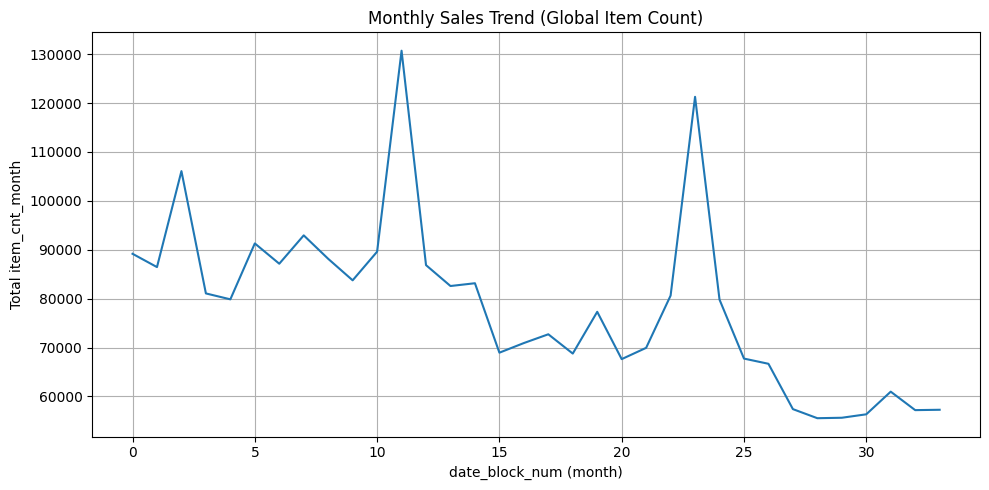

In [ ]:
# monthly sales trend

monthly_sales = (
    df[df["ID"] == -1]  # only training rows (exclude Kaggle test)
      .groupby("date_block_num")["item_cnt_month"]
      .sum()
      .reset_index()
)

plt.figure(figsize=(10, 5))
plt.plot(monthly_sales["date_block_num"], monthly_sales["item_cnt_month"])
plt.title("Monthly Sales Trend (Global Item Count)")
plt.xlabel("date_block_num (month)")
plt.ylabel("Total item_cnt_month")
plt.grid(True)
plt.tight_layout()
plt.show()

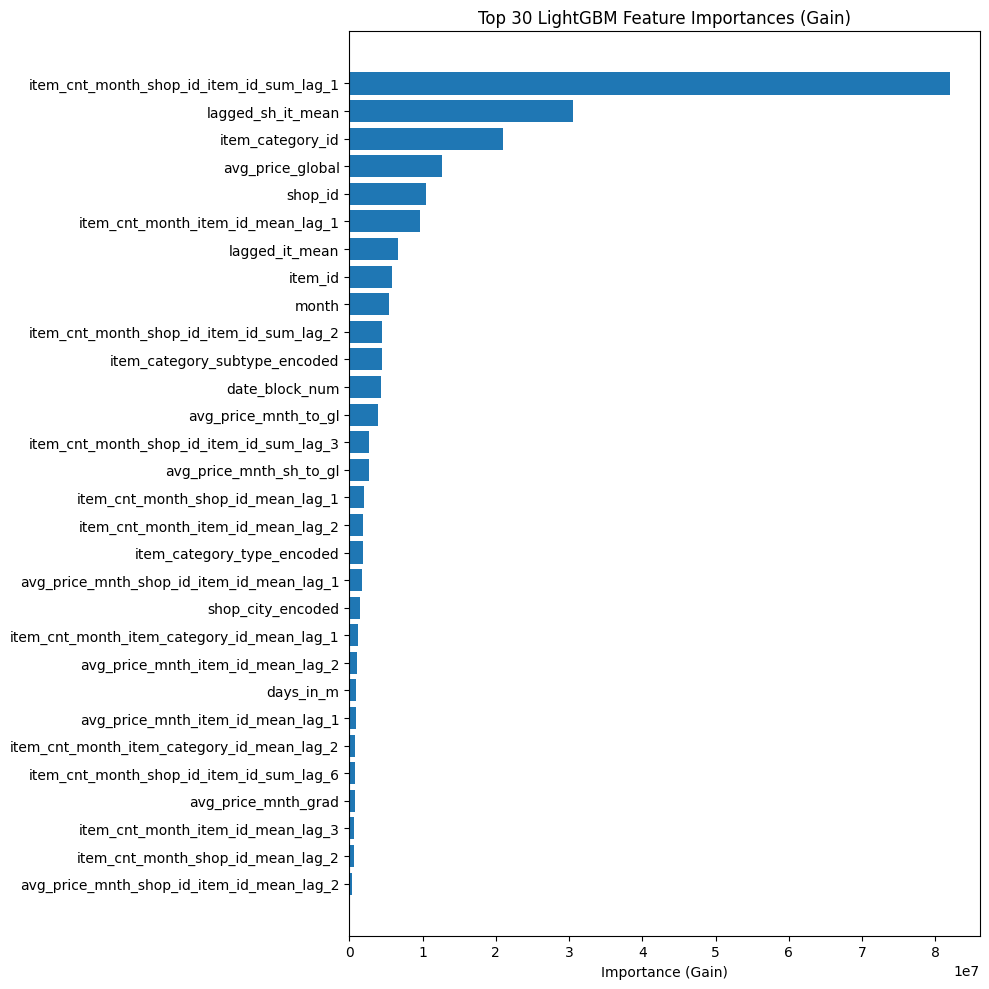

In [ ]:
# LightGBM feature importance

importances = lgb_model.feature_importance(importance_type="gain")
feature_names = np.array(X_train.columns)

idx = np.argsort(importances)[::-1][:30]
top_feats = feature_names[idx]
top_imps = importances[idx]

plt.figure(figsize=(10, 10))
plt.barh(top_feats[::-1], top_imps[::-1])
plt.title("Top 30 LightGBM Feature Importances (Gain)")
plt.xlabel("Importance (Gain)")
plt.tight_layout()
plt.show()


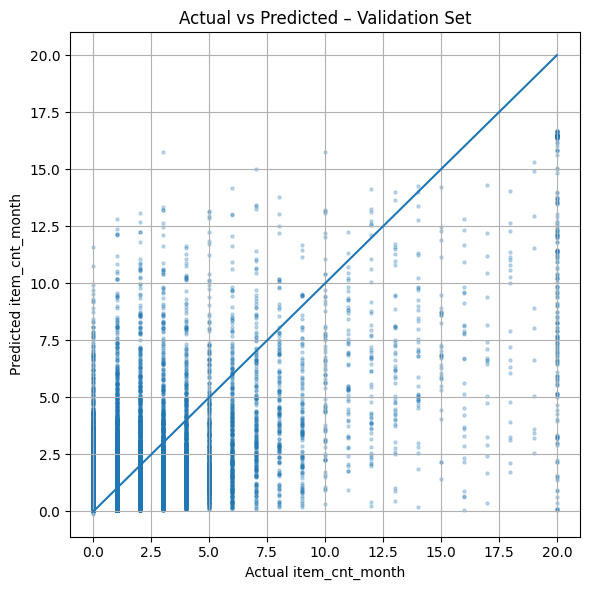

In [ ]:
# actual vs predicted validation set

y_pred_valid = lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration)

plt.figure(figsize=(6, 6))
plt.scatter(y_valid, y_pred_valid, alpha=0.25, s=5)
plt.title("Actual vs Predicted – Validation Set")
plt.xlabel("Actual item_cnt_month")
plt.ylabel("Predicted item_cnt_month")
max_val = max(y_valid.max(), y_pred_valid.max())
plt.plot([0, max_val], [0, max_val])  # 45-degree line
plt.grid(True)
plt.tight_layout()
plt.show()

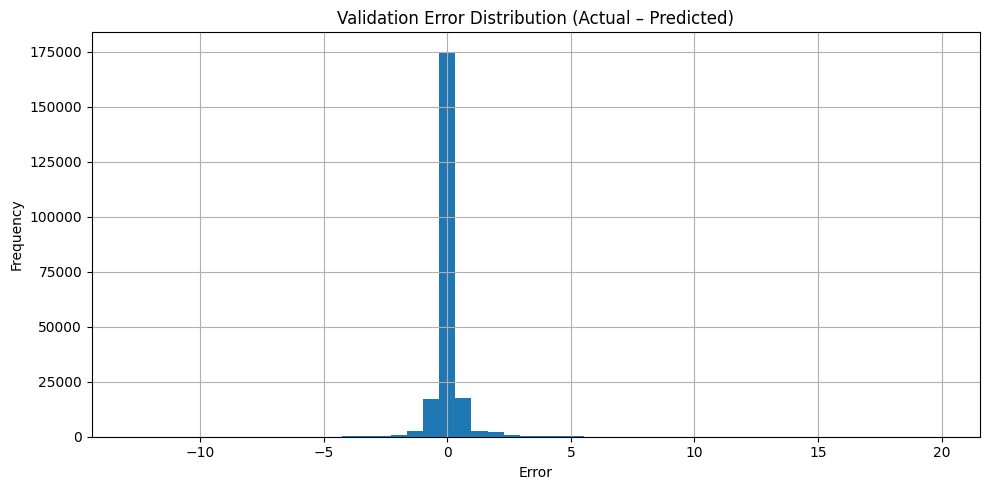

In [ ]:
# validation error distributions

val_errors = y_valid - y_pred_valid

plt.figure(figsize=(10, 5))
plt.hist(val_errors, bins=50)
plt.title("Validation Error Distribution (Actual – Predicted)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


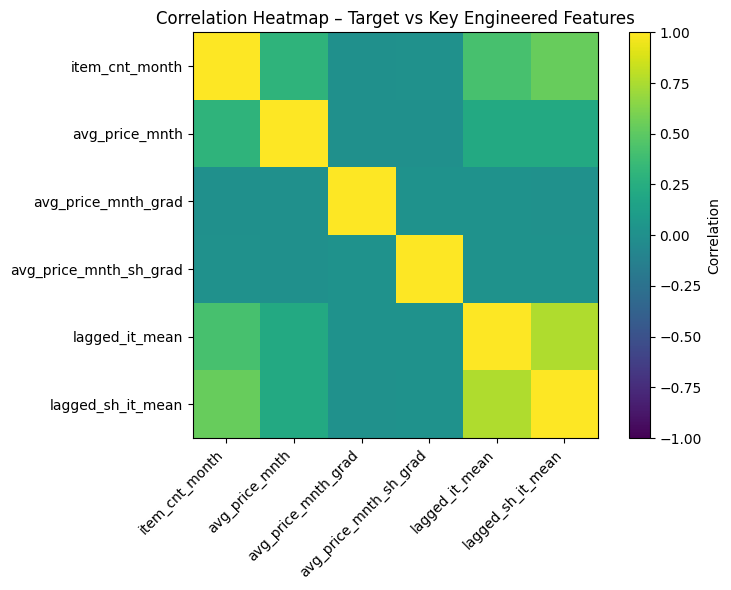

In [ ]:
# heatmap for key factors

corr_cols = [
    "item_cnt_month",
    "avg_price_mnth",          # raw monthly price
    "avg_price_mnth_grad",     # item-level price gradient
    "avg_price_mnth_sh_grad",  # shop–item price gradient
    "lagged_it_mean",
    "lagged_sh_it_mean",
]

# keep only training rows to avoid mixing in test
heat_df = df[df["ID"] == -1][corr_cols].copy()
corr_matrix = heat_df.corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, vmin=-1, vmax=1)
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha="right")
plt.yticks(range(len(corr_cols)), corr_cols)
plt.title("Correlation Heatmap – Target vs Key Engineered Features")
plt.tight_layout()
plt.show()